# **1. Setup**

In [ ]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Bidirectional, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# **2. Load Data**

In [ ]:
# read csv
dataframe = pd.read_csv("https://raw.githubusercontent.com/aungsettpaing/name-gender-corpus/master/name-gender.txt",
                        delimiter="\t",
                        header=None)

# add columns name
dataframe.columns = ["id", "name", "name_syllable", "gender"]

In [ ]:
# check data
dataframe.head(3)

,id,name,name_syllable,gender
0,1,ကိုကို,ကို ကို,male
1,2,ကိုကိုကျော်,ကို ကို ကျော်,male
2,3,ကိုကိုကြည်,ကို ကို ကြည်,male


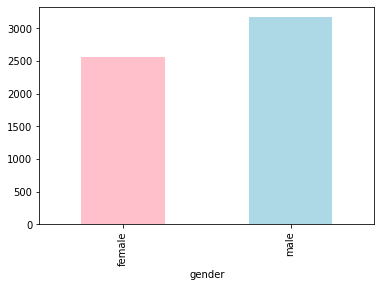

In [ ]:
# Gender distribution
dataframe.groupby("gender")["id"].count().plot(kind="bar", color=["pink", "lightblue"])

In [ ]:
# Create two new columns.
dataframe["syllable_count"] = [len(name.split()) for name in dataframe["name_syllable"]]
dataframe["char_count"] = [len(name) for name in dataframe["name_syllable"]]

In [ ]:
# Check the first 5 rows of dataframe.
dataframe.head()

,id,name,name_syllable,gender,syllable_count,char_count
0,1,ကိုကို,ကို ကို,male,2,7
1,2,ကိုကိုကျော်,ကို ကို ကျော်,male,3,13
2,3,ကိုကိုကြည်,ကို ကို ကြည်,male,3,12
3,4,ကိုကိုကြီး,ကို ကို ကြီး,male,3,12
4,5,ကိုကိုစိုး,ကို ကို စိုး,male,3,12


In [ ]:
# Check the number of syllables and characters of each name information.
dataframe.describe()

,id,syllable_count,char_count
count,5739.000000,5739.000000,5739.000000
mean,2870.000000,2.546088,10.959575
std,1656.850929,0.557368,3.080726
min,1.000000,2.000000,3.000000
25%,1435.500000,2.000000,9.000000
50%,2870.000000,3.000000,10.000000
75%,4304.500000,3.000000,13.000000
max,5739.000000,6.000000,25.000000


# **3. Analysis 1 - (Character Level)**



> In this section, Keras's sequential and dense layers will be used to train and test the modal.



### **3.1 Make Dataset**

In [ ]:
# Make a list to store all characters
vocab = []
name_gender_pair = []

# Get name-gender pairs.
for name, gender in zip(dataframe["name"].tolist(), dataframe["gender"].tolist()):
    # Store all characters.
    for syl in name:
        vocab.append(syl)

    # Pair name and its gender
    name_gender_pair.append((name, gender))
        
# Unique vocabulary (characters)
vocab = set(vocab)
vocab = sorted(vocab)

# classes
classes = dataframe["gender"].unique().tolist()
classes = sorted(classes)

# print number of classes and characters found in all names.
print("Number of classes \t\t :: ", len(classes))
print("Number of name characters \t :: ", len(vocab))

Number of classes 		 ::  2
Number of name characters 	 ::  50


In [ ]:
# Initialize X features and Y labels
X1 = []
Y1 = []

for name_gender in name_gender_pair:
    # Initialize x feature and y label for each name
    features = [0] * len(vocab)
    label = [0] * len(classes)
    
    # Get name and its gender.
    name = name_gender[0]
    gender = name_gender[1]
    
    # Make x features and y labels.
    for syl in name:
        if syl in vocab:
            features[vocab.index(syl)] += 1
            
    label[classes.index(gender)] = 1
    
    # Append x features and y labels into X and Y.
    X1.append(features)
    Y1.append(label)

# Make them numpy arrays.
X1 = np.array(X1)
Y1 = np.array(Y1)
    
# Check their shapes.
print("Dataset X and Y are created!!")
print("Size of X \t :: ", X1.shape)
print("Size of Y \t :: ", Y1.shape)

Dataset X and Y are created!!
Size of X 	 ::  (5739, 50)
Size of Y 	 ::  (5739, 2)


### **3.2 Model Setup**

In [ ]:
# Dictionary to store the accuracy and loss of the modal history
accuracy_loss_results = {"fold #": [], "train accuracy": [], "train loss": [],
                         "validation accuracy": [], "validation loss": []}


# Function for modal creation
def sequential_modal(x_train, y_train, x_test, y_test, verbose=0, fold_no=None, validation=False):

  # create modal
  modal = Sequential()
  modal.add(Dense(128, input_shape=(len(x_train[0]), ), activation="relu"))
  modal.add(Dropout(0.2))
  modal.add(Dense(64, activation="relu"))
  modal.add(Dropout(0.2))
  modal.add(Dense(len(y_train[0]), activation="sigmoid")) 

  # compile modal
  adam = Adam(learning_rate=1e-2)
  modal.compile(loss = "categorical_crossentropy", 
                optimizer = adam,
                metrics = ["accuracy"])
  
  # fit modal
  callback = EarlyStopping(monitor="val_loss",
                           patience=4)
  history = modal.fit(x_train, y_train,
                      epochs = 300,
                      batch_size = 32,
                      verbose = verbose,
                      validation_data = (x_test, y_test),
                      callbacks = [callback])
  
  if validation:
    # Record KFold results
    accuracy_loss_results["fold #"].append(fold_no)
    accuracy_loss_results["train accuracy"].append(history.history["accuracy"][-1])
    accuracy_loss_results["train loss"].append(history.history["loss"][-1])
    accuracy_loss_results["validation accuracy"].append(history.history["val_accuracy"][-1])
    accuracy_loss_results["validation loss"].append(history.history["val_loss"][-1])
  else:
    return modal

### **3.3 Cross Validation**

In [ ]:
# Create a KFold for 10 folds.
stratifiedKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
fold_no = 1

# Loop 10 Fold Times.
for train_index, test_index in stratifiedKFold.split(X1, Y1.argmax(1)):

  # train and test split
  x_train, y_train = X1[train_index], Y1[train_index]
  x_test, y_test = X1[test_index], Y1[test_index]

  # run modal
  sequential_modal(x_train, y_train, x_test, y_test, fold_no=fold_no, validation=True)

  # increment fold_no
  fold_no += 1

In [ ]:
# Print out the accuracy and loss results for each validation.
result_dataframe = pd.DataFrame(accuracy_loss_results)
result_dataframe

,fold #,train accuracy,train loss,validation accuracy,validation loss
0,1,0.880542,0.257304,0.841463,0.346789
1,2,0.887125,0.242976,0.858885,0.311859
2,3,0.878412,0.258080,0.857143,0.318132
3,4,0.876089,0.272731,0.846690,0.331051
4,5,0.866989,0.277021,0.857143,0.326659
5,6,0.876670,0.275358,0.836237,0.331194
6,7,0.876670,0.274670,0.867596,0.313456
7,8,0.870281,0.273701,0.860627,0.341171
8,9,0.891191,0.227714,0.843206,0.395674
9,10,0.889082,0.258592,0.846422,0.363684


### **3.4 Train Modal Again!**



> Train the modal again but for one time so that that can be used to evaluate and predict names.



#### **3.4.1 Split a Dataset**

In [ ]:
# Split the dataset again!
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X1, Y1, test_size=0.2, random_state=42)
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.2, random_state=42)

print("Size of trainX \t :: ", X_TRAIN.shape)
print("Size of trainY \t :: ", Y_TRAIN.shape)
print("Size of testX \t :: ", X_TEST.shape)
print("Size of testY \t :: ", Y_TEST.shape)
print("Size of valX \t :: ", X_VAL.shape)
print("Size of valY \t :: ", Y_VAL.shape)

Size of trainX 	 ::  (3672, 50)
Size of trainY 	 ::  (3672, 2)
Size of testX 	 ::  (1148, 50)
Size of testY 	 ::  (1148, 2)
Size of valX 	 ::  (919, 50)
Size of valY 	 ::  (919, 2)


#### **3.4.2 Train and Evaluate Modal**

In [ ]:
# train modal
modal_1 = sequential_modal(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, verbose=1)

# evaluate modal
tloss, taccuracy = modal_1.evaluate(X_TEST, Y_TEST, batch_size=32)

Epoch 1/300
115/115 [==============================] - 29s 162ms/step - loss: 0.5100 - accuracy: 0.7397 - val_loss: 0.3911 - val_accuracy: 0.8248
Epoch 2/300
115/115 [==============================] - 0s 2ms/step - loss: 0.4094 - accuracy: 0.8075 - val_loss: 0.4115 - val_accuracy: 0.8020
Epoch 3/300
115/115 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.8312 - val_loss: 0.3368 - val_accuracy: 0.8411
Epoch 4/300
115/115 [==============================] - 0s 2ms/step - loss: 0.3413 - accuracy: 0.8480 - val_loss: 0.3378 - val_accuracy: 0.8520
Epoch 5/300
115/115 [==============================] - 0s 3ms/step - loss: 0.3237 - accuracy: 0.8497 - val_loss: 0.3278 - val_accuracy: 0.8618
Epoch 6/300
115/115 [==============================] - 0s 2ms/step - loss: 0.3000 - accuracy: 0.8636 - val_loss: 0.3459 - val_accuracy: 0.8585
Epoch 7/300
115/115 [==============================] - 0s 2ms/step - loss: 0.3026 - accuracy: 0.8638 - val_loss: 0.3292 - val_accuracy: 0.8

#### **3.4.3 Confusion Matrix**

In [ ]:
# predict results
predictions = modal_1.predict(X_TEST)

# get confusion matrix
cf_matrix = confusion_matrix(Y_TEST.argmax(axis=1), predictions.argmax(axis=1))

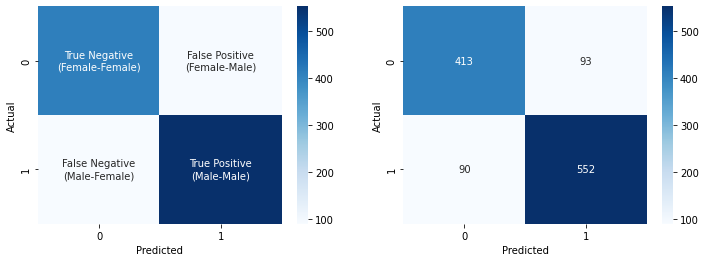

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the confusion matrix description
matrix_labels = np.array([["True Negative\n(Female-Female)", "False Positive\n(Female-Male)"], 
                          ["False Negative\n(Male-Female)", "True Positive\n(Male-Male)"]])
s1 = sns.heatmap(cf_matrix, ax=axs[0], annot=matrix_labels, fmt='', cmap="Blues")
s1.set_xlabel('Predicted')
s1.set_ylabel('Actual')

# Plot the confusion matrix values
s2 = sns.heatmap(cf_matrix, ax=axs[1], annot=True, fmt='', cmap="Blues")
s2.set_xlabel('Predicted')
s2.set_ylabel('Actual')

plt.show()

### **3.5 Testing**

In [ ]:
# Syllabificated names
testin_names = [("ဆု ရ တ နာ", "female"), ("မ လှ တုတ်", "female"), ("မိ မန်း လေး", "female"), ("ဘို ဘို", "male"),
                ("သိန်း တန်", "male"), ("ထွန်း ရင်", "male"), ("စိုး မိုး နိုင်", "male"), ("ခင် ကြည် စိုး", "female"),
                ("ဆင့် ဆင့်", "female"), ("ရဲ ရင့် အောင်", "male"), ("မင်း မော် ကွန်း", "male"), ("အောင် မြင်", "male"),
                ("အေး မင်း ကျော်", "male"), ("ညီ ညီ နိုင်", "male"), ("ပြေ သိမ်း", "male"), ("အိမ် ကံ", "female"),
                ("သိန်း ရှင်", "female"), ("ညို ညို", "female"), ("ကြည် အေး", "female"), ("ခင် ခင် ထူး", "female")]

# Test results dictionary
test_result = {"name": [], "gender": [], "predict": [], "confidence": []}

# Function for testing
def test(names):
  for name in names:
    x = [0] * len(vocab)
    for word in re.sub(" ", "", name[0]):
      if word in vocab:
            x[vocab.index(word)] += 1

    x = np.array(x)
    x.shape = (1, 50)

    result = modal_1.predict(x)
    result_arg = result.argmax()
    result_prob = result[0][result_arg]

    # record the result
    test_result["name"].append(re.sub(" ", "", name[0]))
    test_result["gender"].append(name[1])
    test_result["predict"].append(classes[result_arg])
    test_result["confidence"].append(result_prob)

# Test the modal
test(testin_names)

# Print the result
test_result_dataframe = pd.DataFrame(test_result)
test_result_dataframe

,name,gender,predict,confidence
0,ဆုရတနာ,female,female,0.999950
1,မလှတုတ်,female,female,0.989533
2,မိမန်းလေး,female,female,0.968642
3,ဘိုဘို,male,male,0.995344
4,သိန်းတန်,male,male,0.684031
5,ထွန်းရင်,male,male,0.934881
6,စိုးမိုးနိုင်,male,female,0.718032
7,ခင်ကြည်စိုး,female,male,0.489970
8,ဆင့်ဆင့်,female,male,0.793525
9,ရဲရင့်အောင်,male,male,0.985430




> The same modal but with syllable-level features can predict the above 15 out of 20 testings correctly this time!! But their confidence levels are sometimes strong as almost 99% and weak as 49%.



# **4. Analysis 2 (Syllable Level)**



> In this section, Keras's sequential and dense layers will be used to train and test the modal.



### **4.1 Make a Dataset**

In [ ]:
# Make a list to store all syllables
vocab = []
name_gender_pair = []

# Get name-gender pairs.
for name, gender in zip(dataframe["name_syllable"].tolist(), dataframe["gender"].tolist()):
    # Store all characters.
    for syl in name.split():
        vocab.append(syl)

    # Pair name and its gender
    name_gender_pair.append((name, gender))
        
# Unique vocabulary (syllables)
vocab = set(vocab)
vocab = sorted(vocab)

# classes
classes = dataframe["gender"].unique().tolist()
classes = sorted(classes)

# print number of classes and characters found in all names.
print("Number of classes \t\t :: ", len(classes))
print("Number of name syllables \t :: ", len(vocab))

Number of classes 		 ::  2
Number of name syllables 	 ::  369


In [ ]:
# Initialize X features and Y labels
X2 = []
Y2 = []

for name_gender in name_gender_pair:
    # Initialize x feature and y label for each name
    features = [0] * len(vocab)
    label = [0] * len(classes)
    
    # Get name and its gender.
    name = name_gender[0]
    gender = name_gender[1]
    
    # Make x features and y labels.
    for syl in name:
        if syl in vocab:
            features[vocab.index(syl)] += 1
            
    label[classes.index(gender)] = 1
    
    # Append x features and y labels into X and Y.
    X2.append(features)
    Y2.append(label)

# Make them numpy arrays.
X2 = np.array(X2)
Y2 = np.array(Y2)
    
# Check their shapes.
print("Dataset X and Y are created!!")
print("Size of X \t :: ", X2.shape)
print("Size of Y \t :: ", Y2.shape)

Dataset X and Y are created!!
Size of X 	 ::  (5739, 369)
Size of Y 	 ::  (5739, 2)


### **4.2 Model Setup**

In [ ]:
# Dictionary to store the accuracy and loss of the modal history
accuracy_loss_results = {"fold #": [], "train accuracy": [], "train loss": [],
                         "validation accuracy": [], "validation loss": []}

### **4.3 Cross Validation**

In [ ]:
# Create a KFold for 10 folds.
stratifiedKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
fold_no = 1

# Loop 10 Fold Times.
for train_index, test_index in stratifiedKFold.split(X2, Y2.argmax(1)):

  # train and test split
  x_train, y_train = X2[train_index], Y2[train_index]
  x_test, y_test = X2[test_index], Y2[test_index]

  # run modal
  sequential_modal(x_train, y_train, x_test, y_test, fold_no=fold_no, validation=True)

  # increment fold_no
  fold_no += 1

In [ ]:
# Print out the accuracy and loss results for each validation.
result_dataframe = pd.DataFrame(accuracy_loss_results)
result_dataframe

,fold #,train accuracy,train loss,validation accuracy,validation loss
0,1,0.745983,0.519334,0.710801,0.548390
1,2,0.745208,0.514895,0.724739,0.576819
2,3,0.741142,0.521312,0.722997,0.559235
3,4,0.734560,0.524610,0.740418,0.525372
4,5,0.732430,0.532026,0.726481,0.532198
5,6,0.742885,0.528195,0.716028,0.590190
6,7,0.736883,0.522221,0.764808,0.503786
7,8,0.728170,0.533590,0.749129,0.505724
8,9,0.743078,0.512075,0.695122,0.596505
9,10,0.732869,0.529516,0.745201,0.547711


### **4.4 Train Modal Again!**


> Train the modal again but for one time so that that can be used to evaluate and predict names.


#### **4.4.1 Split a Dataset**

In [ ]:
# Split the dataset again!
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X2, Y2, test_size=0.2, random_state=42)
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.2, random_state=42)

print("Size of trainX \t :: ", X_TRAIN.shape)
print("Size of trainY \t :: ", Y_TRAIN.shape)
print("Size of testX \t :: ", X_TEST.shape)
print("Size of testY \t :: ", Y_TEST.shape)
print("Size of valX \t :: ", X_VAL.shape)
print("Size of valY \t :: ", Y_VAL.shape)

Size of trainX 	 ::  (3672, 369)
Size of trainY 	 ::  (3672, 2)
Size of testX 	 ::  (1148, 369)
Size of testY 	 ::  (1148, 2)
Size of valX 	 ::  (919, 369)
Size of valY 	 ::  (919, 2)


#### **4.4.2 Train and Evaluate Modal**

In [ ]:
# train modal
modal_2 = sequential_modal(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, verbose=1)

# evaluate modal
tloss, taccuracy = modal_2.evaluate(X_TEST, Y_TEST, batch_size=32)

Epoch 1/300
115/115 [==============================] - 2s 7ms/step - loss: 0.6214 - accuracy: 0.6618 - val_loss: 0.5668 - val_accuracy: 0.7291
Epoch 2/300
115/115 [==============================] - 1s 5ms/step - loss: 0.5808 - accuracy: 0.7051 - val_loss: 0.5393 - val_accuracy: 0.7497
Epoch 3/300
115/115 [==============================] - 0s 4ms/step - loss: 0.5587 - accuracy: 0.7190 - val_loss: 0.5509 - val_accuracy: 0.7323
Epoch 4/300
115/115 [==============================] - 0s 4ms/step - loss: 0.5530 - accuracy: 0.7211 - val_loss: 0.5271 - val_accuracy: 0.7399
Epoch 5/300
115/115 [==============================] - 0s 4ms/step - loss: 0.5492 - accuracy: 0.7263 - val_loss: 0.5380 - val_accuracy: 0.7432
Epoch 6/300
115/115 [==============================] - 0s 4ms/step - loss: 0.5435 - accuracy: 0.7236 - val_loss: 0.5381 - val_accuracy: 0.7378
Epoch 7/300
115/115 [==============================] - 1s 5ms/step - loss: 0.5440 - accuracy: 0.7260 - val_loss: 0.5294 - val_accuracy: 0.7465

#### **4.4.3 Confusion Matrix**

In [ ]:
# predict results
predictions = modal_2.predict(X_TEST)

# get confusion matrix
cf_matrix = confusion_matrix(Y_TEST.argmax(axis=1), predictions.argmax(axis=1))

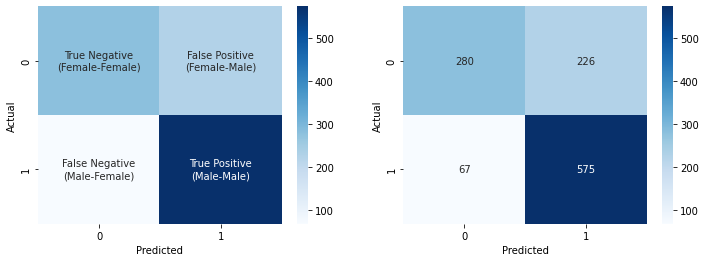

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the confusion matrix description
matrix_labels = np.array([["True Negative\n(Female-Female)", "False Positive\n(Female-Male)"], 
                          ["False Negative\n(Male-Female)", "True Positive\n(Male-Male)"]])
s1 = sns.heatmap(cf_matrix, ax=axs[0], annot=matrix_labels, fmt='', cmap="Blues")
s1.set_xlabel('Predicted')
s1.set_ylabel('Actual')

# Plot the confusion matrix values
s2 = sns.heatmap(cf_matrix, ax=axs[1], annot=True, fmt='', cmap="Blues")
s2.set_xlabel('Predicted')
s2.set_ylabel('Actual')

plt.show()

### **4.5 Testing**

In [ ]:
# Syllabificated names
testin_names = [("ဆု ရ တ နာ", "female"), ("မ လှ တုတ်", "female"), ("မိ မန်း လေး", "female"), ("ဘို ဘို", "male"),
                ("သိန်း တန်", "male"), ("ထွန်း ရင်", "male"), ("စိုး မိုး နိုင်", "male"), ("ခင် ကြည် စိုး", "female"),
                ("ဆင့် ဆင့်", "female"), ("ရဲ ရင့် အောင်", "male"), ("မင်း မော် ကွန်း", "male"), ("အောင် မြင်", "male"),
                ("အေး မင်း ကျော်", "male"), ("ညီ ညီ နိုင်", "male"), ("ပြေ သိမ်း", "male"), ("အိမ် ကံ", "female"),
                ("သိန်း ရှင်", "female"), ("ညို ညို", "female"), ("ကြည် အေး", "female"), ("ခင် ခင် ထူး", "female")]

# Test results dictionary
test_result = {"name": [], "gender": [], "predict": [], "confidence": []}

# Function for testing
def test(names):
  for name in names:
    x = [0] * len(vocab)
    for word in name[0].split():
      if word in vocab:
        x[vocab.index(word)] += 1

    x = np.array(x)
    x.shape = (1, 369)

    result = modal_2.predict(x)
    result_arg = result.argmax()
    result_prob = result[0][result_arg]

    # record the result
    test_result["name"].append(name[0])
    test_result["gender"].append(name[1])
    test_result["predict"].append(classes[result_arg])
    test_result["confidence"].append(result_prob)

# Test the modal
test(testin_names)

# Print the result
test_result_dataframe = pd.DataFrame(test_result)
test_result_dataframe

,name,gender,predict,confidence
0,ဆု ရ တ နာ,female,male,0.564256
1,မ လှ တုတ်,female,male,0.635246
2,မိ မန်း လေး,female,male,0.699234
3,ဘို ဘို,male,male,0.688080
4,သိန်း တန်,male,male,0.707245
5,ထွန်း ရင်,male,male,0.702353
6,စိုး မိုး နိုင်,male,male,0.690266
7,ခင် ကြည် စိုး,female,male,0.692964
8,ဆင့် ဆင့်,female,male,0.695156
9,ရဲ ရင့် အောင်,male,male,0.715089





> The same modal but with syllable-level features can predict the above 11 out of 20 testings correctly this time!! **But their confidence levels are sometimes strong as almost 99% and weak as 51%**.





# **5. Analysis 3 (Character Level)**


> In this section, Keras's Embedding, Bidirectional and LSTM layers are used to train and test again the modal to check whether the accuracy has been improved.



### **5.1 Make a Dataset**

In [ ]:
# keras tokenizer
tokenizer = Tokenizer(oov_token='OOV')

# fit on texts (syllable into integer)
names = dataframe["name"].tolist()

name_list = []
for name in names:
  temp = []
  for n in name:
    temp.append(n)
  name_list.append(" ".join(temp))

tokenizer.fit_on_texts(name_list)

# classes
classes = dataframe["gender"].unique().tolist()
classes = sorted(classes)

# Tranform syllables into their integers
X_encoded = tokenizer.texts_to_sequences(dataframe["name"])
Y_encoded = []

for gender in dataframe["gender"].tolist():
  labels = [0] * len(classes) 
  labels[classes.index(gender)] = 1
  Y_encoded.append(labels)

# Padded with zeros.
X3 = pad_sequences(X_encoded, maxlen=100, padding="post")
Y3 = np.array(Y_encoded)

# print 5 word-index pairs
print("Word-Index Examples :: ", list(tokenizer.word_index.items())[:5])
print("Word-Index Count :: ", len(tokenizer.word_index.items()))
print()
print("Classes :: ", classes)
print()
print("Dataset X and Y are created!!")
print("X  :: ", X3.shape)
print("Y  :: ", Y3.shape)

Word-Index Examples ::  [('OOV', 1), ('်', 2), ('င', 3), ('း', 4), ('ေ', 5)]
Word-Index Count ::  50

Classes ::  ['female', 'male']

Dataset X and Y are created!!
X  ::  (5739, 100)
Y  ::  (5739, 2)


### **5.2 Modal Setup**

In [ ]:
accuracy_loss_results = {"fold #": [], "train accuracy": [], "train loss": [],
                         "validation accuracy": [], "validation loss": []}

def rnn_modal(x_train, y_train, x_test, y_test, fold_no=0, verbose=0, validation=False):
  vocab_size = len(tokenizer.word_index) + 1
  modal = Sequential()
  modal.add(Embedding(vocab_size, 100))
  modal.add(Bidirectional(LSTM(32, dropout=0.2)))
  modal.add(Dense(32, activation="relu"))
  modal.add(Dropout(0.2))
  modal.add(Dense(len(y_train[0]), activation="sigmoid"))

  # compile modal
  adam = Adam(learning_rate=1e-2)
  modal.compile(loss = "categorical_crossentropy", 
                optimizer = adam,
                metrics = ["accuracy"])
  
  # fit modal
  callback = EarlyStopping(monitor="val_loss",
                           patience=4)
  history = modal.fit(x_train, y_train,
                      epochs = 300,
                      batch_size = 32,
                      verbose = verbose,
                      validation_data = (x_test, y_test),
                      callbacks = [callback])
  
  if validation:
    # Record KFold results
    accuracy_loss_results["fold #"].append(fold_no)
    accuracy_loss_results["train accuracy"].append(history.history["accuracy"][-1])
    accuracy_loss_results["train loss"].append(history.history["loss"][-1])
    accuracy_loss_results["validation accuracy"].append(history.history["val_accuracy"][-1])
    accuracy_loss_results["validation loss"].append(history.history["val_loss"][-1])
  else:
    return modal

### **5.3 Cross Validation**

In [ ]:
# Create a KFold for 10 folds.
stratifiedKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
fold_no = 1

# Loop 10 Fold Times.
for train_index, test_index in stratifiedKFold.split(X3, Y3.argmax(1)):

  # train and test split
  x_train, y_train = X3[train_index], Y3[train_index]
  x_test, y_test = X3[test_index], Y3[test_index]

  # run modal
  rnn_modal(x_train, y_train, x_test, y_test, fold_no=fold_no, verbose=1, validation=True)

  # increment the fold_no
  fold_no += 1

Epoch 1/300
162/162 [==============================] - 24s 106ms/step - loss: 0.6900 - accuracy: 0.5464 - val_loss: 0.6873 - val_accuracy: 0.5540
Epoch 2/300
162/162 [==============================] - 13s 83ms/step - loss: 0.6888 - accuracy: 0.5524 - val_loss: 0.6873 - val_accuracy: 0.5540
Epoch 3/300
162/162 [==============================] - 13s 83ms/step - loss: 0.6894 - accuracy: 0.5491 - val_loss: 0.6874 - val_accuracy: 0.5540
Epoch 4/300
162/162 [==============================] - 13s 83ms/step - loss: 0.6879 - accuracy: 0.5524 - val_loss: 0.6876 - val_accuracy: 0.5540
Epoch 5/300
162/162 [==============================] - 14s 84ms/step - loss: 0.6880 - accuracy: 0.5524 - val_loss: 0.6876 - val_accuracy: 0.5540
Epoch 6/300
162/162 [==============================] - 14s 84ms/step - loss: 0.6883 - accuracy: 0.5524 - val_loss: 0.6884 - val_accuracy: 0.5540
Epoch 1/300
162/162 [==============================] - 23s 88ms/step - loss: 0.6901 - accuracy: 0.5487 - val_loss: 0.6886 - val_a

In [ ]:
# Print out the accuracy and loss results for each validation.
result_dataframe = pd.DataFrame(accuracy_loss_results)
result_dataframe

,fold #,train accuracy,train loss,validation accuracy,validation loss
0,1,0.552372,0.688330,0.554007,0.688390
1,2,0.552565,0.687997,0.552265,0.688473
2,3,0.552565,0.688052,0.552265,0.687729
3,4,0.552565,0.687941,0.552265,0.687792
4,5,0.552565,0.688067,0.552265,0.687696
5,6,0.552565,0.687989,0.552265,0.687906
6,7,0.552565,0.687936,0.552265,0.687685
7,8,0.552565,0.688100,0.552265,0.687678
8,9,0.552565,0.687550,0.552265,0.687940
9,10,0.552458,0.688081,0.553229,0.687522


### **5.4 Train Modal Again!**

#### **5.4.1 Split a Dataset**

In [ ]:
# Split the dataset again!
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X3, Y3, test_size=0.2, random_state=42)
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.2, random_state=42)

print("Size of trainX \t :: ", X_TRAIN.shape)
print("Size of trainY \t :: ", Y_TRAIN.shape)
print("Size of testX \t :: ", X_TEST.shape)
print("Size of testY \t :: ", Y_TEST.shape)
print("Size of valX \t :: ", X_VAL.shape)
print("Size of valY \t :: ", Y_VAL.shape)

Size of trainX 	 ::  (3672, 100)
Size of trainY 	 ::  (3672, 2)
Size of testX 	 ::  (1148, 100)
Size of testY 	 ::  (1148, 2)
Size of valX 	 ::  (919, 100)
Size of valY 	 ::  (919, 2)


#### **5.4.2 Train and Evaluate Modal**

In [ ]:
# train modal
modal_3 = rnn_modal(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, verbose=1)

# evaluate modal
tloss, taccuracy = modal_3.evaluate(X_TEST, Y_TEST, batch_size=32)

Epoch 1/300
115/115 [==============================] - 14s 92ms/step - loss: 0.6923 - accuracy: 0.5428 - val_loss: 0.6899 - val_accuracy: 0.5517
Epoch 2/300
115/115 [==============================] - 10s 85ms/step - loss: 0.6888 - accuracy: 0.5507 - val_loss: 0.6881 - val_accuracy: 0.5517
Epoch 3/300
115/115 [==============================] - 10s 84ms/step - loss: 0.6890 - accuracy: 0.5507 - val_loss: 0.6880 - val_accuracy: 0.5517
Epoch 4/300
115/115 [==============================] - 10s 84ms/step - loss: 0.6885 - accuracy: 0.5507 - val_loss: 0.6878 - val_accuracy: 0.5517
Epoch 5/300
115/115 [==============================] - 10s 84ms/step - loss: 0.6886 - accuracy: 0.5507 - val_loss: 0.6888 - val_accuracy: 0.5517
Epoch 6/300
115/115 [==============================] - 10s 84ms/step - loss: 0.6887 - accuracy: 0.5507 - val_loss: 0.6878 - val_accuracy: 0.5517
Epoch 7/300
115/115 [==============================] - 10s 85ms/step - loss: 0.6884 - accuracy: 0.5507 - val_loss: 0.6878 - val_ac

#### **5.4.3 Confusion Matrix**

In [ ]:
# predict results
predictions = modal_3.predict(X_TEST)

# get confusion matrix
cf_matrix = confusion_matrix(Y_TEST.argmax(axis=1), predictions.argmax(axis=1))

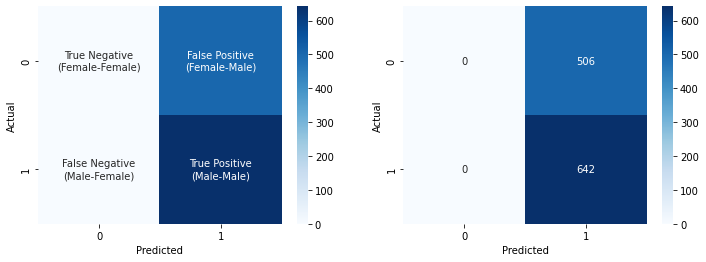

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the confusion matrix description
matrix_labels = np.array([["True Negative\n(Female-Female)", "False Positive\n(Female-Male)"], 
                          ["False Negative\n(Male-Female)", "True Positive\n(Male-Male)"]])
s1 = sns.heatmap(cf_matrix, ax=axs[0], annot=matrix_labels, fmt='', cmap="Blues")
s1.set_xlabel('Predicted')
s1.set_ylabel('Actual')

# Plot the confusion matrix values
s2 = sns.heatmap(cf_matrix, ax=axs[1], annot=True, fmt='', cmap="Blues")
s2.set_xlabel('Predicted')
s2.set_ylabel('Actual')

plt.show()

### **5.5 Testing**

In [ ]:
# Syllabificated names
testin_names = [("ဆု ရ တ နာ", "female"), ("မ လှ တုတ်", "female"), ("မိ မန်း လေး", "female"), ("ဘို ဘို", "male"),
                ("သိန်း တန်", "male"), ("ထွန်း ရင်", "male"), ("စိုး မိုး နိုင်", "male"), ("ခင် ကြည် စိုး", "female"),
                ("ဆင့် ဆင့်", "female"), ("ရဲ ရင့် အောင်", "male"), ("မင်း မော် ကွန်း", "male"), ("အောင် မြင်", "male"),
                ("အေး မင်း ကျော်", "male"), ("ညီ ညီ နိုင်", "male"), ("ပြေ သိမ်း", "male"), ("အိမ် ကံ", "female"),
                ("သိန်း ရှင်", "female"), ("ညို ညို", "female"), ("ကြည် အေး", "female"), ("ခင် ခင် ထူး", "female")]

# Test results dictionary
test_result = {"name": [], "gender": [], "predict": [], "confidence": []}

# Function for testing
def test(names):
  for name in names:
    x = tokenizer.texts_to_sequences([" ".join(name[0].split())])
    x = pad_sequences(x, maxlen=100, padding="post")

    result = modal_3.predict(x)
    result_arg = result.argmax()
    result_prob = result[0][result_arg]

    # record the result
    test_result["name"].append(re.sub(" ", "", name[0]))
    test_result["gender"].append(name[1])
    test_result["predict"].append(classes[result_arg])
    test_result["confidence"].append(result_prob)

# Test the modal
test(testin_names)

# Print the result
test_result_dataframe = pd.DataFrame(test_result)
test_result_dataframe

,name,gender,predict,confidence
0,ဆုရတနာ,female,male,0.523732
1,မလှတုတ်,female,male,0.523732
2,မိမန်းလေး,female,male,0.523732
3,ဘိုဘို,male,male,0.523732
4,သိန်းတန်,male,male,0.523732
5,ထွန်းရင်,male,male,0.523732
6,စိုးမိုးနိုင်,male,male,0.523732
7,ခင်ကြည်စိုး,female,male,0.523732
8,ဆင့်ဆင့်,female,male,0.523732
9,ရဲရင့်အောင်,male,male,0.523732


# **6. Analysis 4 (Syllable Level)**



> In this section, Keras's Embedding, Bidirectional and LSTM layers are used to train and test again the modal to check whether the accuracy has been improved.





### **6.1 Make a Dataset**

In [ ]:
# keras tokenizer
tokenizer = Tokenizer(oov_token='OOV')

# fit on texts (syllable into integer)
tokenizer.fit_on_texts(dataframe["name_syllable"])

# classes
classes = dataframe["gender"].unique().tolist()
classes = sorted(classes)

# Tranform syllables into their integers
X_encoded = tokenizer.texts_to_sequences(dataframe["name_syllable"])
Y_encoded = []

for gender in dataframe["gender"].tolist():
  labels = [0] * len(classes) 
  labels[classes.index(gender)] = 1
  Y_encoded.append(labels)

# Padded with zeros.
X4 = pad_sequences(X_encoded, maxlen=10, padding="post")
Y4 = np.array(Y_encoded)

# print 5 word-index pairs
print("Word-Index Examples :: ", list(tokenizer.word_index.items())[:5])
print()
print("Classes :: ", classes)
print()
print("Dataset X and Y are created!!")
print("X  :: ", X4.shape)
print("Y  :: ", Y4.shape)

Word-Index Examples ::  [('OOV', 1), ('ခင်', 2), ('အောင်', 3), ('ဝင်း', 4), ('မြင့်', 5)]

Classes ::  ['female', 'male']

Dataset X and Y are created!!
X  ::  (5739, 10)
Y  ::  (5739, 2)


### **6.2 Modal Setup**

In [ ]:
accuracy_loss_results = {"fold #": [], "train accuracy": [], "train loss": [],
                         "validation accuracy": [], "validation loss": []}

def rnn_modal(x_train, y_train, x_test, y_test, fold_no=0, verbose=0, validation=False):
  vocab_size = len(tokenizer.word_index) + 1
  modal = Sequential()
  modal.add(Embedding(vocab_size, 10))
  modal.add(Bidirectional(LSTM(32, dropout=0.2)))
  modal.add(Dense(32, activation="relu"))
  modal.add(Dropout(0.2))
  modal.add(Dense(len(y_train[0]), activation="sigmoid"))

  # compile modal
  adam = Adam(learning_rate=1e-2)
  modal.compile(loss = "categorical_crossentropy", 
                optimizer = adam,
                metrics = ["accuracy"])
  
  # fit modal
  callback = EarlyStopping(monitor="val_loss",
                           patience=4)
  history = modal.fit(x_train, y_train,
                      epochs = 300,
                      batch_size = 32,
                      verbose = verbose,
                      validation_data = (x_test, y_test),
                      callbacks = [callback])
  
  if validation:
    # Record KFold results
    accuracy_loss_results["fold #"].append(fold_no)
    accuracy_loss_results["train accuracy"].append(history.history["accuracy"][-1])
    accuracy_loss_results["train loss"].append(history.history["loss"][-1])
    accuracy_loss_results["validation accuracy"].append(history.history["val_accuracy"][-1])
    accuracy_loss_results["validation loss"].append(history.history["val_loss"][-1])
  else:
    return modal

### **6.3 Cross Validation**


In [ ]:
# Create a KFold for 10 folds.
stratifiedKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
fold_no = 1

# Loop 10 Fold Times.
for train_index, test_index in stratifiedKFold.split(X4, Y4.argmax(1)):

  # train and test split
  x_train, y_train = X4[train_index], Y4[train_index]
  x_test, y_test = X4[test_index], Y4[test_index]

  # run modal
  rnn_modal(x_train, y_train, x_test, y_test, fold_no=fold_no, verbose=0, validation=True)

  # increment the fold_no
  fold_no += 1

In [ ]:
# Print out the accuracy and loss results for each validation.
result_dataframe = pd.DataFrame(accuracy_loss_results)
result_dataframe

,fold #,train accuracy,train loss,validation accuracy,validation loss
0,1,0.901646,0.197449,0.886760,0.254410
1,2,0.901258,0.200672,0.886760,0.253207
2,3,0.902807,0.192896,0.878049,0.258245
3,4,0.907841,0.175966,0.862369,0.283832
4,5,0.906680,0.184045,0.905923,0.243618
5,6,0.901065,0.214809,0.881533,0.261781
6,7,0.912294,0.172790,0.911150,0.211699
7,8,0.900678,0.213614,0.890244,0.242008
8,9,0.907067,0.188218,0.881533,0.244725
9,10,0.906698,0.184913,0.890052,0.250028


### **6.4 Train Modal Again!**



> Train the modal again but for one time so that that can be used to evaluate and predict names.



#### **6.4.1 Split a Dataset**

In [ ]:
# Split the dataset again!
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X4, Y4, test_size=0.2, random_state=42)
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X_TRAIN, Y_TRAIN, test_size=0.2, random_state=42)

print("Size of trainX \t :: ", X_TRAIN.shape)
print("Size of trainY \t :: ", Y_TRAIN.shape)
print("Size of testX \t :: ", X_TEST.shape)
print("Size of testY \t :: ", Y_TEST.shape)
print("Size of valX \t :: ", X_VAL.shape)
print("Size of valY \t :: ", Y_VAL.shape)

Size of trainX 	 ::  (3672, 10)
Size of trainY 	 ::  (3672, 2)
Size of testX 	 ::  (1148, 10)
Size of testY 	 ::  (1148, 2)
Size of valX 	 ::  (919, 10)
Size of valY 	 ::  (919, 2)


#### **6.4.2 Train and Evaluate Modal**

In [ ]:
# train modal
modal_4 = rnn_modal(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, verbose=1)

# evaluate modal
tloss, taccuracy = modal_4.evaluate(X_TEST, Y_TEST, batch_size=32)

Epoch 1/300
115/115 [==============================] - 6s 17ms/step - loss: 0.4057 - accuracy: 0.7974 - val_loss: 0.2509 - val_accuracy: 0.9010
Epoch 2/300
115/115 [==============================] - 1s 9ms/step - loss: 0.2724 - accuracy: 0.8791 - val_loss: 0.2479 - val_accuracy: 0.9032
Epoch 3/300
115/115 [==============================] - 1s 9ms/step - loss: 0.2520 - accuracy: 0.8832 - val_loss: 0.2319 - val_accuracy: 0.9010
Epoch 4/300
115/115 [==============================] - 1s 8ms/step - loss: 0.2307 - accuracy: 0.8889 - val_loss: 0.2451 - val_accuracy: 0.9010
Epoch 5/300
115/115 [==============================] - 1s 8ms/step - loss: 0.2211 - accuracy: 0.8960 - val_loss: 0.2170 - val_accuracy: 0.9064
Epoch 6/300
115/115 [==============================] - 1s 8ms/step - loss: 0.2137 - accuracy: 0.8911 - val_loss: 0.2316 - val_accuracy: 0.9032
Epoch 7/300
115/115 [==============================] - 1s 8ms/step - loss: 0.2077 - accuracy: 0.8943 - val_loss: 0.2311 - val_accuracy: 0.909

#### **6.4.3 Confusion Matrix**

In [ ]:
# predict results
predictions = modal_4.predict(X_TEST)

# get confusion matrix
cf_matrix = confusion_matrix(Y_TEST.argmax(axis=1), predictions.argmax(axis=1))

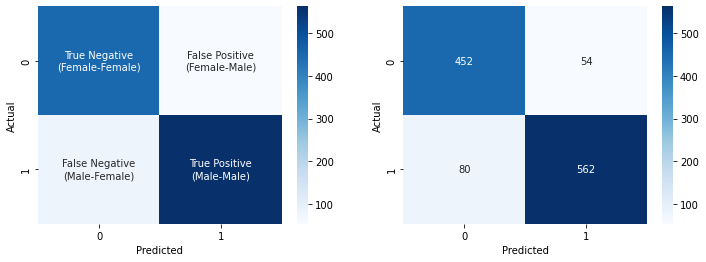

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the confusion matrix description
matrix_labels = np.array([["True Positive\n(Female-Female)", "False Positive\n(Female-Male)"], 
                          ["False Negative\n(Male-Female)", "True Positive\n(Male-Male)"]])
s1 = sns.heatmap(cf_matrix, ax=axs[0], annot=matrix_labels, fmt='', cmap="Blues")
s1.set_xlabel('Predicted')
s1.set_ylabel('Actual')

# Plot the confusion matrix values
s2 = sns.heatmap(cf_matrix, ax=axs[1], annot=True, fmt='', cmap="Blues")
s2.set_xlabel('Predicted')
s2.set_ylabel('Actual')

plt.show()

### **6.5 Testing**

In [ ]:
# Syllabificated names
testin_names = [("ဆု ရ တ နာ", "female"), ("မ လှ တုတ်", "female"), ("မိ မန်း လေး", "female"), ("ဘို ဘို", "male"),
                ("သိန်း တန်", "male"), ("ထွန်း ရင်", "male"), ("စိုး မိုး နိုင်", "male"), ("ခင် ကြည် စိုး", "female"),
                ("ဆင့် ဆင့်", "female"), ("ရဲ ရင့် အောင်", "male"), ("မင်း မော် ကွန်း", "male"), ("အောင် မြင်", "male"),
                ("အေး မင်း ကျော်", "male"), ("ညီ ညီ နိုင်", "male"), ("ပြေ သိမ်း", "male"), ("အိမ် ကံ", "female"),
                ("သိန်း ရှင်", "female"), ("ညို ညို", "female"), ("ကြည် အေး", "female"), ("ခင် ခင် ထူး", "female")]

# Test results dictionary
test_result = {"name": [], "gender": [], "predict": [], "confidence": []}

# Function for testing
def test(names):
  for name in names:
    x = tokenizer.texts_to_sequences([" ".join(name[0].split())])
    x = pad_sequences(x, maxlen=10, padding="post")

    result = modal_4.predict(x)
    result_arg = result.argmax()
    result_prob = result[0][result_arg]

    # record the result
    test_result["name"].append(re.sub(" ", "", name[0]))
    test_result["gender"].append(name[1])
    test_result["predict"].append(classes[result_arg])
    test_result["confidence"].append(result_prob)

# Test the modal
test(testin_names)

# Print the result
test_result_dataframe = pd.DataFrame(test_result)
test_result_dataframe

,name,gender,predict,confidence
0,ဆုရတနာ,female,female,0.999983
1,မလှတုတ်,female,female,0.999724
2,မိမန်းလေး,female,female,0.997065
3,ဘိုဘို,male,male,0.997877
4,သိန်းတန်,male,male,0.947728
5,ထွန်းရင်,male,male,0.894445
6,စိုးမိုးနိုင်,male,male,0.656959
7,ခင်ကြည်စိုး,female,female,0.997923
8,ဆင့်ဆင့်,female,male,0.996749
9,ရဲရင့်အောင်,male,male,0.996988




> The same modal but with syllable-level features can predict the above 16 out of 20 testings correctly this time!! But their confidence levels are sometimes strong as almost 99% and weak as 49%.

